# Feature Importance Analysis

## Introduction
In the previous notebook, we found *groups* of variables (Factors). Now, we want to answer a more direct question: **"What is causing the damage?"**

If we have a building in poor condition, is it because of the rain? The age? The salt?

**Feature Importance** helps us rank these suspects. We use Machine Learning models to predict the condition of a building based on its data. Then, we ask the model: "Which variable helped you the most in making that prediction?"

We will use two powerful algorithms:
1. **Random Forest**: Imagine asking a committee of 100 experts for their opinion and taking the average. It's very stable and reliable.
2. **Gradient Boosting**: Imagine a student taking a test, then studying *only* the questions they got wrong, and taking it again. It learns from mistakes and can be very accurate.

In this notebook, we will:
1. **Split the Data**: Separate our data into "Study Material" (Train) and "Exam Questions" (Test).
2. **Train Models**: Teach the computer to predict building condition.
3. **Extract Importance**: Find out which variables matter most.

## Understanding Machine Learning Terminology

Before we start, let's demystify some terms you'll see. **Don't worry** — you don't need to be a programmer to use these tools!

### **Core Concepts**

#### **1. sklearn (scikit-learn) — The Toolbox**

**What it is**: A library (collection) of pre-built machine learning tools.

**Analogy**: Like a workshop full of power tools. You don't need to know how to build a drill; you just need to know how to use one.

**In practice**:
```python
from sklearn.ensemble import RandomForestRegressor  # Get a tool
model = RandomForestRegressor()  # Take it out of the box
```

#### **2. Fit — Teaching the Model**

**What it means**: The model learns patterns from your data.

**Analogy**: Like showing a student 100 examples of "good" vs. "bad" essays so they learn what makes a good essay.

**In practice**:
```python
model.fit(X_train, y_train)  # "Learn from these examples"
```

**What happens**: The model finds patterns like "buildings with high moisture + old age tend to have low condition ratings."

#### **3. Predict — Using What It Learned**

**What it means**: Apply learned patterns to new data.

**Analogy**: The student (model) now grades new essays based on what they learned.

**In practice**:
```python
predictions = model.predict(X_test)  # "What do you think about these new buildings?"
```

#### **4. Hyperparameters — Settings You Choose**

**What they are**: Options you set **before** training the model.

**Analogy**: Like camera settings (aperture, shutter speed) you adjust before taking a photo.

**Examples**:
```python
RandomForestRegressor(
    n_estimators=100,  # How many trees? (more = slower but often better)
    max_depth=10,      # How deep can each tree grow? (deeper = more complex)
    random_state=42    # Random seed (for reproducibility)
)
```

**Don't stress about these!** The defaults work well. We'll use sensible values.

#### **5. Overfitting — Memorizing Instead of Learning**

**What it is**: Model memorizes training data instead of learning general patterns.

**Analogy**: 
- **Good learning**: Student understands essay principles → grades new essays well
- **Overfitting**: Student memorizes the 100 example essays → can't grade new ones

**How to detect**:
- Model performs great on training data (R² = 0.95)
- Model performs poorly on test data (R² = 0.30)
- **Gap between training and test performance** = overfitting

**How to prevent**:
- Use train-test split (we'll do this!)
- Don't make model too complex
- Have enough data

#### **6. Train-Test Split — The Honesty Check**

**What it is**: Divide data into two groups:
- **Training set** (80%): Model learns from this
- **Test set** (20%): Model has never seen this — honest performance check

**Analogy**: 
- Training set = practice exams the student studies
- Test set = final exam with new questions

**Why it matters**: Prevents overfitting. If model does well on test set, it truly learned (not just memorized).

---

### **The Standard Workflow (You'll See This Pattern Repeatedly)**

```python
# 1. Import the tool
from sklearn.ensemble import RandomForestRegressor

# 2. Create the model (with settings)
model = RandomForestRegressor(n_estimators=100, random_state=42)

# 3. Teach it (fit)
model.fit(X_train, y_train)

# 4. Use it (predict)
predictions = model.predict(X_test)

# 5. Check how well it did
score = model.score(X_test, y_test)
```

**Every model follows this pattern!** Once you understand it once, you understand them all.

---

### **Key Takeaway**

You don't need to understand the math inside sklearn. You need to:
1. ✓ Prepare your data correctly
2. ✓ Choose a model (we'll guide you)
3. ✓ Fit it to training data
4. ✓ Test it on test data
5. ✓ Interpret the results

**The notebooks handle the technical details. You focus on the preservation questions!**

Let's get started:

## Step 0: Upload Your Data (Google Colab Users)

If you're running this in **Google Colab**, you need to upload the `processed_data.csv` file from Notebook 1.

In [1]:
# Uncomment the lines below if you want to upload via code
# from google.colab import files
# uploaded = files.upload()
# print("File uploaded successfully!")

## Why Random Forest and Gradient Boosting?

This notebook uses **Random Forest** and **Gradient Boosting** as the default models. But there are many other machine learning algorithms! Here's why we chose these two, and when you might consider alternatives.

### Models We Use (Default)

#### **Random Forest**
✓ **Strengths**:
- Handles non-linear relationships automatically
- Robust to outliers
- Provides built-in feature importance
- Works well with small-to-medium datasets (100-1000 observations)
- Minimal tuning required
- Provides uncertainty estimates (prediction intervals)

✗ **Weaknesses**:
- Can be slow with very large datasets (10,000+ observations)
- Less interpretable than linear models
- May overfit with very noisy data

**Best for**: General-purpose heritage preservation analysis with mixed variable types

#### **Gradient Boosting (XGBoost/LightGBM)**
✓ **Strengths**:
- Often highest accuracy
- Excellent feature importance rankings
- Handles missing data well
- Can capture complex interactions

✗ **Weaknesses**:
- More sensitive to overfitting
- Requires more careful tuning
- Can be unstable with very small datasets (<100 obs)
- Less robust to outliers than Random Forest

**Best for**: When you need maximum accuracy and have clean data

---

### Other Models to Consider

#### **Ridge Regression** (Linear with Regularization)
**When to use**:
- Relationships appear mostly **linear**
- You have **multicollinearity** (correlated predictors)
- You need **interpretable coefficients** for stakeholders
- Small datasets (<50 observations)

**Example**: "Each 1mm increase in rainfall predicts 0.3mm increase in crack width"

**Advantage**: Simple, transparent, easy to explain  
**Limitation**: Can't capture non-linear relationships or interactions  
**Learn more**: `sklearn.linear_model.Ridge` ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html))

#### **Lasso Regression** (Feature Selection)
**When to use**:
- You have **many variables** (20+) and want to identify the most important
- You suspect **many variables are irrelevant**
- You want **automatic feature selection**

**How it works**: Automatically sets unimportant variable coefficients to exactly zero

**Advantage**: Built-in feature selection, sparse models  
**Limitation**: Can be unstable when predictors are highly correlated  
**Learn more**: `sklearn.linear_model.Lasso` ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html))

#### **Elastic Net** (Ridge + Lasso Hybrid)
**When to use**:
- You want **both regularization and feature selection**
- You have **correlated predictors** (common in heritage data)
- Lasso alone is too aggressive

**Advantage**: Balances Ridge and Lasso strengths  
**Limitation**: Requires tuning two hyperparameters  
**Learn more**: `sklearn.linear_model.ElasticNet` ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html))

#### **Support Vector Machines (SVM)**
**When to use**:
- You have **small-to-medium datasets** (<1000 observations)
- Relationships are **complex but smooth**
- You want to **classify** deterioration levels (e.g., Low/Medium/High)

**Advantage**: Effective in high-dimensional spaces, versatile kernels  
**Limitation**: Slow with large datasets, harder to interpret  
**Learn more**: `sklearn.svm.SVR` for regression ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html))

#### **Neural Networks (Deep Learning)**
**When to use**:
- You have **very large datasets** (1000+ observations)
- Relationships are **highly complex and non-linear**
- You have **image data** (e.g., crack detection from photos)
- Traditional methods plateau in performance

**Advantage**: Can learn extremely complex patterns  
**Limitation**: Requires lots of data, computationally expensive, black-box  
**Learn more**: `sklearn.neural_network.MLPRegressor` ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)) or TensorFlow/PyTorch for deep learning

#### **K-Nearest Neighbors (KNN)**
**When to use**:
- You have **small datasets** with **clear clusters**
- Similar buildings should have similar outcomes
- You want a **simple, intuitive** approach

**How it works**: "This building is similar to these 5 buildings, so predict their average condition"

**Advantage**: Simple, no training required, intuitive  
**Limitation**: Slow predictions, sensitive to irrelevant features  
**Learn more**: `sklearn.neighbors.KNeighborsRegressor` ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html))

---

### Decision Guide: Which Model Should I Use?

| Scenario | Recommended Model | Why |
|----------|-------------------|-----|
| **Small dataset (<50 obs)** | Ridge Regression or Simple Regression | Linear models more stable with limited data |
| **Linear relationships** | Ridge/Lasso/Elastic Net | Simpler models, easier to interpret |
| **Many irrelevant variables** | Lasso or Random Forest | Automatic feature selection |
| **Non-linear relationships** | Random Forest or Gradient Boosting | Handle curves and interactions |
| **Need interpretability** | Ridge Regression or Decision Tree | Clear coefficients or rules |
| **Maximum accuracy** | Gradient Boosting (XGBoost) | State-of-the-art performance |
| **Lots of missing data** | Random Forest or Gradient Boosting | Handle missingness naturally |
| **Very large dataset (10,000+)** | Gradient Boosting or Neural Networks | Scalable algorithms |
| **Image/spatial data** | Neural Networks (CNNs) | Designed for image patterns |
| **Unsure what to try** | **Random Forest** (our default) | Robust, versatile, good starting point |

---

### How to Try Other Models

All these models are available in **scikit-learn**. The code structure is nearly identical:

```python
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Ridge Regression
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train, y_train)
y_pred_ridge = model_ridge.predict(X_test)

# Random Forest (what we use)
model_rf = RandomForestRegressor(n_estimators=100)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

# Support Vector Machine
model_svm = SVR(kernel='rbf')
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_test)

# Compare performance
from sklearn.metrics import r2_score
print(f"Ridge R²: {r2_score(y_test, y_pred_ridge):.3f}")
print(f"Random Forest R²: {r2_score(y_test, y_pred_rf):.3f}")
print(f"SVM R²: {r2_score(y_test, y_pred_svm):.3f}")
```

---

### Resources for Learning More

**Scikit-learn Documentation**:
- [Choosing the right estimator](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) - Interactive flowchart
- [Model comparison guide](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html)
- [All regression models](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning)

**Books**:
- *Hands-On Machine Learning with Scikit-Learn* by Aurélien Géron (beginner-friendly)
- *An Introduction to Statistical Learning* by James et al. (free PDF, excellent for heritage practitioners)

**Online Courses**:
- [Google's Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course) (free)
- [Coursera: Machine Learning Specialization](https://www.coursera.org/specializations/machine-learning-introduction) by Andrew Ng

---

### Bottom Line

**For most heritage preservation projects**: Stick with **Random Forest** and **Gradient Boosting** (what this notebook uses). They're robust, versatile, and handle the messy reality of heritage data well.

**Consider alternatives when**:
- You need simpler, more interpretable models (→ Ridge/Lasso)
- You have very small datasets (→ Ridge Regression)
- You have very large datasets (→ Neural Networks)
- Random Forest/Gradient Boosting give poor results (→ try others)

**Pro tip**: Try 2-3 models and compare their R² and MAE. The best model for your specific data might surprise you!

---

Now let's proceed with Random Forest and Gradient Boosting:

### Important: Temporal and Spatial Validation for Heritage Data

#### Why Standard Random Splits Can Be Problematic

Heritage datasets often have **temporal structure** (measurements over time) or **spatial structure** (buildings in same district). Random train-test splits can create **data leakage** by mixing temporally or spatially adjacent observations, inflating apparent accuracy.

**Example of data leakage**:
- You have condition ratings for Building A from 2015, 2016, 2017, 2018, 2019, 2020
- Random split puts 2015, 2017, 2019 in training and 2016, 2018, 2020 in testing
- Model learns patterns from 2017 and 2019 to predict 2018 → **not realistic!**
- In real use, you'd predict 2020 using only data up to 2019

#### Temporal Validation (Time-Series Data)

**When to use**: Your data spans multiple years and you want to predict future conditions

**How it works**: Train on earlier years, test on later years

**Example**:
```python
# Assume you have a 'Year' column
train_data = df[df['Year'] <= 2017]  # Train on 2010-2017
test_data = df[df['Year'] >= 2018]   # Test on 2018-2020

X_train = train_data[feature_columns]
y_train = train_data[target_column]
X_test = test_data[feature_columns]
y_test = test_data[target_column]
```

**Benefits**:
- ✓ Realistic: Tests if model can predict future
- ✓ No data leakage: Future doesn't inform past
- ✓ Honest performance estimate

**When to use**: Predicting deterioration trends, planning future interventions

#### Spatial Validation (Geographic Data)

**When to use**: Buildings are clustered in districts/neighborhoods with shared environmental conditions

**How it works**: Train on some districts, test on others

**Example**:
```python
# Assume you have a 'District' column
train_districts = ['North', 'East', 'West']
test_districts = ['South', 'Central']

train_data = df[df['District'].isin(train_districts)]
test_data = df[df['District'].isin(test_districts)]

X_train = train_data[feature_columns]
y_train = train_data[target_column]
X_test = test_data[feature_columns]
y_test = test_data[target_column]
```

**Benefits**:
- ✓ Tests generalization to new locations
- ✓ Reveals if model relies on district-specific patterns
- ✓ Useful for expanding monitoring to new areas

**When to use**: Planning district-wide interventions, expanding to new neighborhoods

#### Decision Guide

| Your Data Structure | Recommended Split | Why |
|---------------------|-------------------|-----|
| **Time-series** (same buildings measured over years) | Temporal | Predict future from past |
| **Geographic clusters** (districts with shared conditions) | Spatial | Test generalization to new areas |
| **Both temporal and spatial** | Temporal first, then spatial | Most conservative test |
| **Independent observations** (different buildings, single time) | Random | Standard approach is fine |

#### For This Tutorial

Our synthetic dataset has both temporal (Year_Built) and spatial (District) structure. For simplicity, we'll use a **random split** below, but in real heritage projects, **strongly consider temporal or spatial validation** for more honest performance estimates.

**To implement temporal/spatial splits**: Modify the code below to filter by Year or District instead of using `train_test_split()`.

---

Now let's proceed with the standard train-test split:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Set consistent styling
sns.set_style("white")
sns.set_palette("viridis")

# Load processed data
try:
    df = pd.read_csv('processed_data.csv')
    print("✅ Data loaded successfully!")
    print(f"   Shape: {df.shape}")
except FileNotFoundError:
    print("❌ ERROR: 'processed_data.csv' not found.")
    print("Please run Notebook 1 (Data Preparation) first, or upload the file.")
    raise

# Define Target and Features
# Target (y): What we want to predict -> 'Condition_Rating'
# Features (X): The data we use to predict it -> Everything else (except IDs)
target = 'Condition_Rating'
drop_cols = ['Building_ID', 'Condition_Rating', 'Intervention_Urgency']

X = df.drop(columns=drop_cols)
y = df[target]

print(f"\nFeatures (X): {len(X.columns)} variables")
print(f"Target (y): {target}")
print(f"\nTarget distribution:")
print(y.value_counts().sort_index())

✅ Data loaded successfully!
   Shape: (200, 24)

Features (X): 21 variables
Target (y): Condition_Rating

Target distribution:
Condition_Rating
1    40
2    40
3    40
4    40
5    40
Name: count, dtype: int64


## 1. Train-Test Split

If we teach the computer using *all* our data, it might just memorize the answers. This is called **overfitting**.

To test if it actually *learned* the patterns, we hide some data from it.
- **Training Set (80%)**: The computer studies this data to learn the rules.
- **Testing Set (20%)**: We use this to test the computer. It has never seen these buildings before.

It's exactly like a teacher holding back some questions from the textbook to use on the final exam.

> **Pro Tip on Data Leakage**: In this tutorial, we scaled our data *before* splitting it. In a strict professional environment, you should split the data first, then scale it. Why? Because calculating the average of the *whole* dataset gives the training set a tiny "peek" at the test set's data. For learning purposes here, pre-scaling is fine, but keep this in mind for production systems!

### Interpreting R² for Heritage Preservation Datasets

#### What is R² (R-squared)?

R² measures **how much of the variation in your outcome variable is explained by your model**:
- **R² = 0.0**: Model explains nothing (no better than guessing the average)
- **R² = 0.5**: Model explains 50% of variation
- **R² = 1.0**: Model explains everything (perfect prediction)

#### Heritage-Specific Benchmarks

Heritage deterioration data is inherently **complex and noisy** due to:
- Unmeasured variables (historical interventions, material quality variations)
- Measurement uncertainty (sensor placement, timing)
- Stochastic processes (weather events, human activities)
- Long time scales (decades of accumulated effects)

**Therefore, R² values for heritage data are typically LOWER than in controlled experiments.**

#### Interpretation Guidelines for Heritage Datasets

| R² Range | Interpretation | Practical Value | Action |
|----------|----------------|-----------------|--------|
| **< 0.3** | Weak model | Limited practical value | Model may not be useful; try different variables or methods |
| **0.3 - 0.5** | Moderate model | Useful for prioritization | Good enough to identify high-risk vs. low-risk buildings |
| **0.5 - 0.7** | Good model | Reliable for decision-making | Confident predictions; use for resource allocation |
| **> 0.7** | Excellent model | Rare but very valuable | Exceptional for heritage data; validate carefully |

#### Why 0.4-0.6 is Often "Good Enough"

**Example**: R² = 0.5 for predicting condition rating

This means:
- ✓ Model explains 50% of why some buildings deteriorate faster
- ✓ Can identify top 20% highest-risk buildings with confidence
- ✓ Better than random guessing or expert intuition alone
- ✗ Still 50% unexplained (other factors, randomness)

**For prioritization decisions** ("which buildings need attention first?"), R² = 0.4-0.6 is **sufficient**.

**For precise predictions** ("exactly how much will this crack grow?"), you'd want R² > 0.7.

#### Focus on Practical Improvement, Not Perfect Prediction

**Key question**: Does the model **meaningfully improve** your decision-making?

**Example comparison**:
- **No model**: Inspect all 200 buildings equally → Find 30 high-risk buildings
- **Model with R² = 0.5**: Inspect top 50 predicted high-risk → Find 25 of the 30 high-risk buildings
- **Result**: 75% less inspection effort, 83% of problems found → **Huge practical value!**

Even a "moderate" R² = 0.4-0.5 can **dramatically improve resource allocation** compared to no model.

#### What About MAE (Mean Absolute Error)?

MAE is often **more interpretable** than R² because it's in the same units as your outcome.

**Example**: Predicting condition rating on a 1-5 scale
- **MAE = 0.3**: Typical prediction is off by 0.3 rating points → Excellent
- **MAE = 0.5**: Typical prediction is off by 0.5 rating points → Good for prioritization
- **MAE = 1.0**: Typical prediction is off by 1 full rating point → Marginal utility
- **MAE = 1.5+**: Predictions too inaccurate to be useful

**Rule of thumb**: MAE should be **< 20% of your outcome variable's range**
- For 1-5 scale (range = 4): MAE < 0.8 is acceptable
- For 0-100 scale (range = 100): MAE < 20 is acceptable

#### Summary

**For heritage preservation datasets**:
- ✓ **R² = 0.4-0.6** is typically **useful and actionable**
- ✓ **R² < 0.3** suggests model has limited value
- ✓ **R² > 0.7** is excellent but uncommon (validate carefully!)
- ✓ **MAE** should be < 20% of outcome range
- ✓ Focus on **practical improvement** over perfect prediction

**Don't be discouraged by "moderate" R² values** — they can still provide enormous practical value for prioritization and resource allocation!

---

Now let's look at our model's performance:

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Total Buildings: {len(df)}")
print(f"Training with: {X_train.shape[0]} buildings ({X_train.shape[0]/len(df)*100:.0f}%)")
print(f"Testing on: {X_test.shape[0]} buildings ({X_test.shape[0]/len(df)*100:.0f}%)")

Total Buildings: 200
Training with: 160 buildings (80%)
Testing on: 40 buildings (20%)


## 2. Random Forest Model

We create a **Random Forest Regressor**. 

**Hyperparameters explained:**
- `n_estimators=100`: We are creating a "forest" of 100 decision trees. More trees = more stable predictions, but slower.
- `random_state=42`: This is a "seed" that ensures we get the same result every time we run this code. The number 42 is arbitrary (a reference to "The Hitchhiker's Guide to the Galaxy").

After training (`.fit()`), we ask it to predict the condition of the test buildings (`.predict()`).

**Evaluating the Model:**
- **R-squared ($R^2$)**: How well the model explains the variance (0 to 1). 1.0 is perfect.
- **Mean Absolute Error (MAE)**: On average, how far off is our prediction? If MAE is 0.5, it means if the real rating is 3.0, our model might guess 2.5 or 3.5. Lower is better.

In [4]:
print("Training Random Forest...")
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate
y_pred_rf = rf.predict(X_test)
score_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"\n✅ Random Forest Results:")
print(f"   R² Score: {score_rf:.3f} (closer to 1.0 is better)")
print(f"   MAE: {mae_rf:.3f} points (average prediction error)")
print(f"   Interpretation: On average, predictions are off by {mae_rf:.2f} rating points.")

Training Random Forest...

✅ Random Forest Results:
   R² Score: 0.187 (closer to 1.0 is better)
   MAE: 1.148 points (average prediction error)
   Interpretation: On average, predictions are off by 1.15 rating points.


## 3. Gradient Boosting Model

Now we try a different student: **Gradient Boosting**. It often performs better but can be more sensitive to noise.

**How it differs from Random Forest:**
- Random Forest builds all trees independently and averages them.
- Gradient Boosting builds trees sequentially, with each new tree trying to fix the errors of the previous ones.

In [5]:
print("Training Gradient Boosting...")
gb = GradientBoostingRegressor(n_estimators=100, random_state=42)
gb.fit(X_train, y_train)

# Evaluate
y_pred_gb = gb.predict(X_test)
score_gb = r2_score(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)

print(f"\n✅ Gradient Boosting Results:")
print(f"   R² Score: {score_gb:.3f}")
print(f"   MAE: {mae_gb:.3f} points")
print(f"   Interpretation: On average, predictions are off by {mae_gb:.2f} rating points.")

Training Gradient Boosting...

✅ Gradient Boosting Results:
   R² Score: 0.122
   MAE: 1.199 points
   Interpretation: On average, predictions are off by 1.20 rating points.


## Model Comparison

Let's compare the two models side-by-side:


Model Performance Comparison:


,Model,R² Score,MAE (points)
0,Random Forest,0.187241,1.14825
1,Gradient Boosting,0.121766,1.19905



🏆 Random Forest performed better (higher R²)


/var/folders/t0/r5nh9gq553jgwbsh46rsbhr00000gn/T/ipykernel_86820/1541848612.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R² Score', data=comparison, palette='viridis')


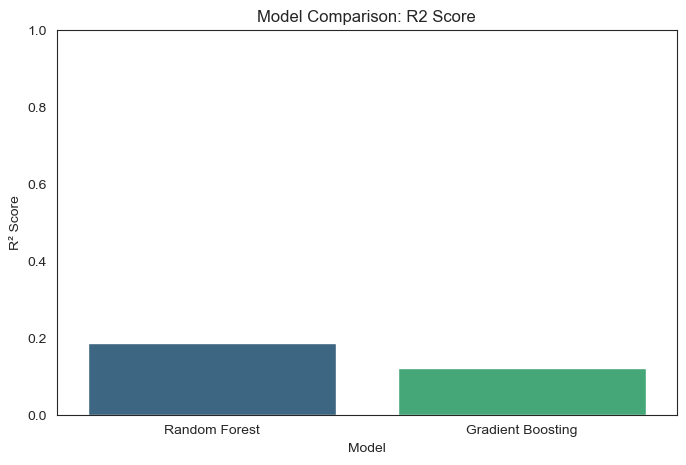

In [6]:
comparison = pd.DataFrame({
    'Model': ['Random Forest', 'Gradient Boosting'],
    'R² Score': [score_rf, score_gb],
    'MAE (points)': [mae_rf, mae_gb]
})

print("\nModel Performance Comparison:")
display(comparison)

# Determine winner
if score_rf > score_gb:
    print(f"\n🏆 Random Forest performed better (higher R²)")
    best_model = rf
    best_name = "Random Forest"
else:
    print(f"\n🏆 Gradient Boosting performed better (higher R²)")
    best_model = gb
    best_name = "Gradient Boosting"
# Visualize Model Comparison
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='R² Score', data=comparison, palette='viridis')
plt.title('Model Comparison: R2 Score')
plt.ylim(0, 1)
plt.savefig('figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


## 4. Visualizing Feature Importance

This is the most important part! We ask the models: **"What was the most useful variable?"**

The bar chart below ranks the variables. 
- **Tall bars**: These variables are the main drivers of deterioration.
- **Short bars**: These variables don't matter much for this specific problem.

**Interpretation Tip**: If "Crack Width" is the top bar, it means existing damage is the best predictor of future rating (which makes sense!). If "Rainfall" is the top bar, it means the environment is the main driver.

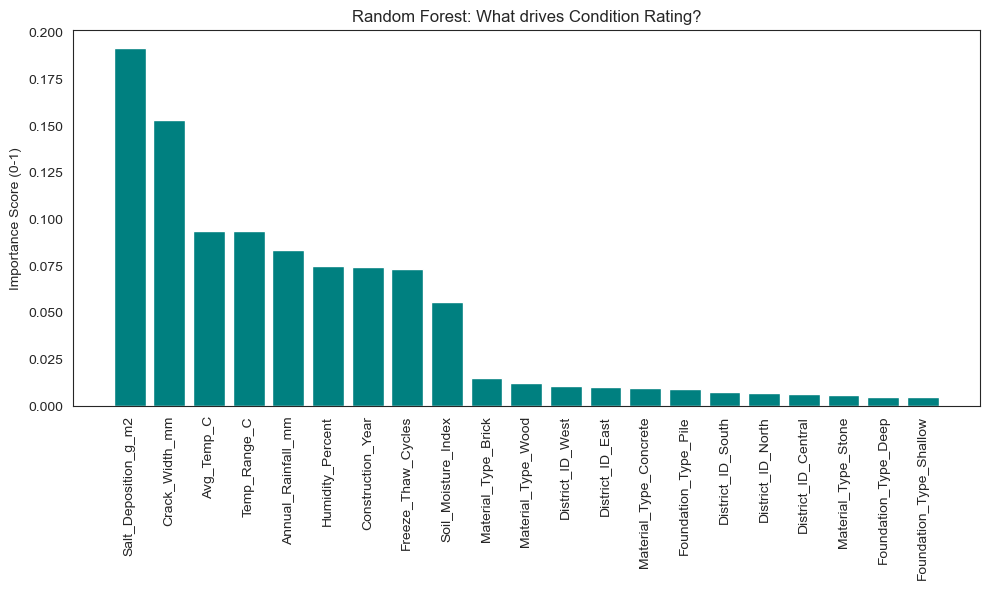


Top 5 Most Important Features (Random Forest: What drives Condition Rating?):
  1. Salt_Deposition_g_m2: 0.192
  2. Crack_Width_mm: 0.153
  3. Avg_Temp_C: 0.094
  4. Temp_Range_C: 0.094
  5. Annual_Rainfall_mm: 0.084


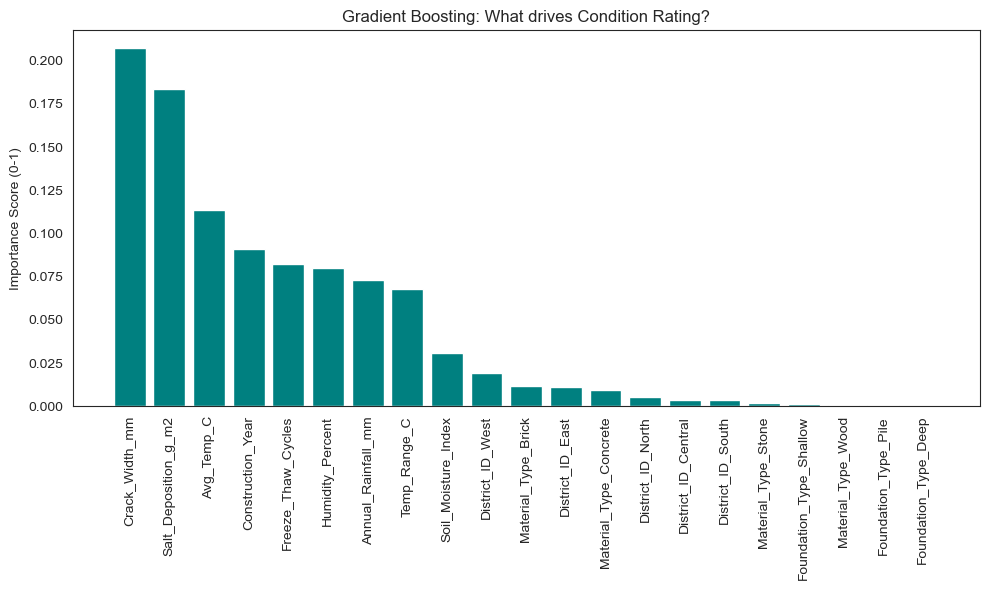


Top 5 Most Important Features (Gradient Boosting: What drives Condition Rating?):
  1. Crack_Width_mm: 0.207
  2. Salt_Deposition_g_m2: 0.184
  3. Avg_Temp_C: 0.114
  4. Construction_Year: 0.091
  5. Freeze_Thaw_Cycles: 0.082


In [7]:
def plot_importance(model, feature_names, title):
    importances = model.feature_importances_
    # Sort the feature importance in descending order
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(X.shape[1]), importances[indices], align="center", color='teal')
    plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
    plt.ylabel("Importance Score (0-1)")
    plt.tight_layout()
    plt.savefig('figures/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print top 5
    print(f"\nTop 5 Most Important Features ({title}):")
    for i in range(min(5, len(indices))):
        idx = indices[i]
        print(f"  {i+1}. {feature_names[idx]}: {importances[idx]:.3f}")

plot_importance(rf, X.columns, "Random Forest: What drives Condition Rating?")
plot_importance(gb, X.columns, "Gradient Boosting: What drives Condition Rating?")

## Saving Results

Let's save the feature importance rankings for use in reports.

In [8]:
# Create importance dataframe
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'RF_Importance': rf.feature_importances_,
    'GB_Importance': gb.feature_importances_
}).sort_values('RF_Importance', ascending=False)

importance_df.to_csv('feature_importance.csv', index=False)
print("✅ Saved feature_importance.csv")

# Save model comparison
comparison.to_csv('model_comparison.csv', index=False)
print("✅ Saved model_comparison.csv")

# Optional: Download in Colab
# from google.colab import files
# files.download('feature_importance.csv')
# files.download('model_comparison.csv')

✅ Saved feature_importance.csv
✅ Saved model_comparison.csv


## Troubleshooting

**Common Issues:**

1. **Low R² score (< 0.3)**: Your features may not predict the target well. This could mean:
   - The target variable is influenced by factors not in your dataset
   - You need more data
   - The relationship is too complex for these models

2. **High MAE**: If MAE is close to 1.0 or higher, predictions are very inaccurate. Consider:
   - Adding more relevant features
   - Checking for data quality issues
   - Using a different target variable

3. **One feature dominates**: If one feature has importance > 0.8, it might be:
   - A "leakage" variable (e.g., using future information)
   - The only truly relevant predictor
   - Check if this makes physical sense!

4. **Models disagree on importance**: This is normal! Different algorithms weight features differently. Look for features that rank high in BOTH models.

**Tips:**
- If results seem wrong, always validate with domain expertise
- Feature importance shows correlation, not causation
- Consider removing highly correlated features for clearer results

## Next Steps

Now that you know which features drive deterioration:

1. **Prioritize monitoring**: Focus sensors/surveys on the top-ranked variables.
2. **Guide interventions**: If environmental factors rank high, consider protective measures. If structural factors dominate, focus on repairs.
3. **Proceed to Notebook 4**: Create visualizations to communicate these findings to stakeholders.

**Key Takeaway**: The top 3-5 features typically account for 70-80% of predictive power. Focus your resources there!